In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

#Needed for training and evaluation
from losses import *
from RandomMatrixDataSet import get_sample,RandomMatrixDataSet,SingularvalueMatrix, EigenMatrix
from train import train_on_batch, run_training
from evaluation import *
from plotting import plot_loss_logs, error_histogram, plot_mean_identity_approx

#Seed and looks
torch.random.seed = 1234
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [132]:
import math
from typing import Tuple
from typing import Optional

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerModel(nn.Module):

    def __init__(self, out_size: int, d_model: int, nhead: int, d_hid: int = 64,
                 nlayers: int = 2, dropout: float = 0.5, max_pos_len: int = 10000, pos_enc_dim: int = 8):
        
        super().__init__()
        
        # The position encoding is concatenated to the input
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, max_pos_len, pos_enc_dim)
        encoder_layers = TransformerEncoderLayer(d_model + 2 * pos_enc_dim, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        # This is what I added in terms of decoder 
        # decoder_layers = TransformerDecoderLayer(d_model,nhead)
        # self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        
        #This used to be nn.Embedding
        # self.embedding = MatrixEmbedding(d_model) 
        
        self.d_model = d_model
        self.generator = nn.Linear(d_model + 2 * pos_enc_dim, d_model) 

        self.init_weights()
    
    #This could probably be modified/tuned
    def init_weights(self) -> None:
        initrange = 0.1
        # self.embedding.linear.weight.data.uniform_(-initrange, initrange)
        self.generator.bias.data.zero_()
        self.generator.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor, tgt: Tensor, tgt_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [batch_size, seq_len, dimensionality]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [batch_size, seq_len, ntoken]
        """
        #print(src)
        # src_embedded = self.embedding(src) * math.sqrt(self.d_model)
        #print(src_embedded)
        
        unfolded = F.unfold(src, kernel_size=(2,2)).squeeze(1)

        src_pos_encoded = self.pos_encoder(unfolded)
        
        #print(src_pos_encoded)
        # encoded_src = self.transformer_encoder(src_pos_encoded, src_mask)
        
        encoded_src = self.transformer_encoder(src_pos_encoded)
        # print(f'==[ encoded_src: {encoded_src}')
        
        output = self.generator(encoded_src) 
        #print(output)
        return output  #This is without a transformer decoder
        
        #Added this for the decoder  
        # tgt_embedded = self.embedding(tgt)*math.sqrt(self.d_model) #
        # decoder_output = self.transformer_decoder(self.pos_encoder(encoded_src),encoded_src)
        # return self.generator(decoder_output) #This is with decoder


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int = 4, max_len: int = 10000, pos_enc_dim: int = 8):
        super().__init__()
        
        # NOTE: We keep d_model as a parameter, but it is not actually used here.
        # In the original paper, they *add* the position encoding
        # to the token vector, but in this instance we concatenate
        # the two, so it is not necessary to know the dimensionality
        # of the input here.

        if pos_enc_dim < 8:
            pos_enc_dim = 8
        
        # Primes up to the position encoding dimensionality
        prm = primes(pos_enc_dim)
        # print(f'==[ prm:\n{prm}')
        
        # Frequencies
        freqs = torch.from_numpy(prm)[:,None].repeat(1, max_len)
        # print(f'==[ freqs:\n{freqs.shape}')
        
        # Lengths (up to max_len)
        lengths = torch.linspace(0, max_len - 1, max_len)[None,:].repeat(pos_enc_dim, 1)
        # print(f'==[ lengths.shape:\n{lengths.shape}')
        
        # Imaginary unit
        i = complex(0,1)
        
        # Instead of cos and sin, use the relation e^{iwk} = cos(wk) + i sin(wk).
        # Create a tensor of all (i*w*k) values.
        pe = torch.exp((i * lengths * freqs))
        
        # Use the real and imaginary parts of the computed values as the position encoding
        pe = torch.cat((pe.real[:,None], pe.imag[:,None]), 1).flatten(end_dim=1)[None,:,:]

        # print(f'==[ pe: {pe.shape}')
        # print(f'==[ pe[:,0]: {pe[:,0]}')
        
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, embedding_dim, seq_len]
        """ 
        # Slice of the positional encoding matrix e
        # equal to the length of the input (batched)
        # print(f'==[ x shape:\n{x.shape}')
        
        pos_enc = self.pe[:,:,:x.shape[2]]
        # print(f'==[ pos_enc shape:\n{pos_enc.shape}')

        # Concatenate the input and the position encodings
        x = torch.cat((x, pos_enc.repeat(x.shape[0],1,1)), 1).permute(0,2,1)
        # print(f'==[ x.shape:\n{x.shape}')
    
        return x
    
# class MatrixEmbedding(nn.Module):
#     """ """
#     def __init__(self,d_model: int = 4):
#         super().__init__()
#         self.d_model = d_model
        
#     def forward(self, x: Tensor):
        
#         x = x.unsqueeze(-1)
#         m = torch.arange(x.shape[0]) 
#         #return x #torch.cat((x,m[:,None,None]), 2) #embed with index. Only works with d_model = 2
#         return torch.cat(self.d_model*[x], 2) #Just stack the tensor

### Here I generate a src-tgt pair to validate the pipe-line (or a test set)

In [133]:
N = 32
d = 10
mp = {"N": N,
      "d": d}
# Need to generate matrix data. These are just random matrices 
def get_batch(matrix_parameters):
    M = get_sample(matrix_parameters)
    M.compute_labels()
    # print(f'==[ M.X:\n{M.X}')
    data = torch.permute(torch.flatten(M.X, start_dim = 1),(1,0))
    target = torch.permute(torch.flatten(M.Y, start_dim = 1),(1,0))
    # return data, target
    return M.X, target
                         
src,tgt = get_batch(mp)
# print(src, tgt)
# print(f'==[ Matrix:\n{M.X}')
# print(f'==[ Matrix shape:\n{M.X.shape}')

# unfolded = F.unfold(src, kernel_size=(2,2)).squeeze(1)
# print(f'==[ Unfolded:\n{unfolded}')
# print(f'==[ Unfolded shape:\n{unfolded.shape}')

# pos_encoder= PositionalEncoding()
# pos_encoder.forward(unfolded)

## Initiate an instance

In [134]:
ntokens = d**2 # Size of output
pos_enc_dim = 8 # Size of the position embedding
emsize = 4  # Embedding dimensions (default is 4 = 2 x 2 convolution size)
d_hid = 9  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.0  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout, pos_enc_dim = pos_enc_dim)#.to(device)


#Some normalization found from another source
#for p in model.parameters():
#    if p.dim() > 1:
#        nn.init.xavier_uniform_(p)

In [135]:
#model(d,src_mask,t,tgt_mask)

In [136]:
torch.set_printoptions(precision=8)

In [137]:
import copy
import time

#Data parameters (Not using at the moment)
# d = 3
batch_size = 32
mp = {"N":batch_size,
      "d": d}


#I am not entirely sure about the masks
src_mask = generate_square_subsequent_mask(d**2) #A fixed matrix size to begin with
tgt_mask = generate_square_subsequent_mask(d**2) # -||- 

#Training parameters
k = 1000

criterion = nn.MSELoss()

# #This is the loss Ive used in previous training
# def relative_inv_MSE(predicted,x):
#     #Normalize with batch square mean?
#     id = torch.eye(x.shape[1])
#     id_approx = torch.matmul(predicted,x)
#     return (id_approx - id).square().mean() #/id_approx.square().mean()).mean()  #((id_approx - id).square()/x.square().mean()).mean()#
# criterion = relative_inv_MSE

lr = 1e-3 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

model.train()  # turn on train mode

# ------------------------------------------------------------------------------
# A single step for debugging purposes!
# ------------------------------------------------------------------------------

#This is from the tutorial 
#batch_size = data.size(0) 
#if batch_size != bptt:  # only on last batch
#    src_mask = src_mask[:batch_size, :batch_size]
output = model(src, src_mask, tgt, tgt_mask).permute(0,2,1)

print(f'==[ output:\n{output.shape}')


out = F.fold(output, kernel_size=(2,2), output_size=(d,d)).squeeze().flatten(start_dim=1)
tgt = tgt.permute(1,0)

print(f'==[ output:\n{out.shape}')
print(f'==[ target:\n{tgt.shape}')

==[ output:
torch.Size([16, 4, 196])
==[ output:
torch.Size([16, 225])
==[ target:
torch.Size([16, 225])


In [138]:
def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(d**2).to(device)

    #num_batches = len(train_data) // bptt
    for i in range(k):
        #Currently just trying to overfit it on one matrix 
        # data, targets = src, tgt #get_batch(matrix_parameters)
        data, targets = get_batch(mp)
        
        #This is from the tutorial 
        #batch_size = data.size(0) 
        #if batch_size != bptt:  # only on last batch
        #    src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask, targets, tgt_mask).permute(0,2,1)

        output = F.fold(output, kernel_size=(2,2), output_size=(d,d)).squeeze().flatten(start_dim=1)
        targets = targets.permute(1,0)

        #If we want to use (Xf(X)- 1) loss 
        loss = criterion(data.reshape(-1,d,d), output.reshape(-1,d,d))
        
        #For trying other loss functions
        #loss = criterion(output, targets)
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        
        if i % log_interval == 0 and i > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            #ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {i:5d} batches | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.5f}')
            # print(f'| epoch {epoch:3d} | {i:5d} batches | '
            #      f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
            #      f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()
           
#Not using this at the moment
def evaluate(model: nn.Module, eval_parameters) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(d**2).to(device)
    with torch.no_grad():
        data, targets = get_batch(eval_parameters)
        targets = targets.permute(1,0)
            #batch_size = data.size(0)
            #if batch_size != bptt:
            #    src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask, targets, tgt_mask)
        output = F.fold(output, kernel_size=(2,2), output_size=(d,d)).squeeze().flatten(start_dim=1)
        
        output_flat = output.view(-1, ntokens)
        total_loss += batch_size * criterion(output_flat, targets.reshape(-1,ntokens)).item()
    return total_loss / (eval_parameters["N"] - 1)

In [139]:
best_val_loss = float('inf')
epochs = 10
best_model = None
eval_parameters = {"N": 100,
                   "d": d}
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
   #  val_loss = evaluate(model, eval_parameters)
   #  print(f'==[ val_loss: {val_loss}')
   #  val_ppl = math.exp(val_loss)
   #  elapsed = time.time() - epoch_start_time
   #  print('-' * 89)
   #  print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
   #       f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
   #  print('-' * 89)

   #  if val_loss < best_val_loss:
   #     best_val_loss = val_loss
   #     best_model = copy.deepcopy(model)

    scheduler.step()

| epoch   1 |   200 batches | lr 0.0010 | ms/batch  6.77 | loss 0.18477
| epoch   1 |   400 batches | lr 0.0010 | ms/batch  6.52 | loss 0.05200
| epoch   1 |   600 batches | lr 0.0010 | ms/batch  6.33 | loss 0.03913
| epoch   1 |   800 batches | lr 0.0010 | ms/batch  6.23 | loss 0.03089
| epoch   2 |   200 batches | lr 0.0009 | ms/batch  5.76 | loss 0.01847
| epoch   2 |   400 batches | lr 0.0009 | ms/batch  5.78 | loss 0.01378
| epoch   2 |   600 batches | lr 0.0009 | ms/batch  5.83 | loss 0.01129
| epoch   2 |   800 batches | lr 0.0009 | ms/batch  5.86 | loss 0.00956
| epoch   3 |   200 batches | lr 0.0009 | ms/batch  5.86 | loss 0.00706
| epoch   3 |   400 batches | lr 0.0009 | ms/batch  5.88 | loss 0.00624
| epoch   3 |   600 batches | lr 0.0009 | ms/batch  6.47 | loss 0.00566
| epoch   3 |   800 batches | lr 0.0009 | ms/batch  5.84 | loss 0.00528
| epoch   4 |   200 batches | lr 0.0009 | ms/batch  5.79 | loss 0.00463
| epoch   4 |   400 batches | lr 0.0009 | ms/batch  5.74 | loss 

In [143]:

out = model(src,src_mask,tgt,tgt_mask).permute(0,2,1)

out = F.fold(out, kernel_size=(2,2), output_size=(d,d)).squeeze().flatten(start_dim=1)
# print(out) #Just goes to some (or two) fixed values 
#print(t)
mia = torch.matmul(tgt.reshape(-1,d,d), out.reshape(-1,d,d)).mean(0)
mia = mia.detach().numpy()       

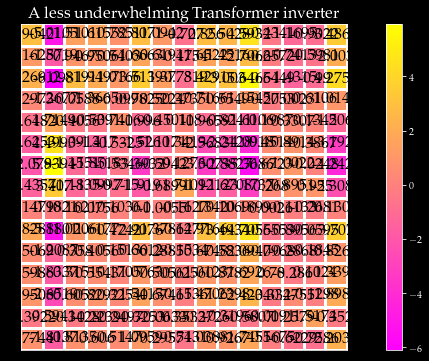

In [144]:
fig = plt.figure()

ax = fig.add_subplot()


img = ax.imshow(mia, cmap='spring')
for i in range(d):
    for j in range(d):
        t = ax.text(j, i, round(mia[i, j], 4),
                        ha="center", va="center", color="black", fontsize=16)
    # Create colorbar
cbar = ax.figure.colorbar(img, ax=ax)
ax.set_xticks(np.arange(0, d, 1) + 0.5)
ax.set_yticks(np.arange(0, d, 1) + 0.5)
ax.set_title('Mean $f(X)X$', fontsize=18)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_title("A less underwhelming Transformer inverter", fontsize = 16)
ax.grid(color="w", linestyle='-', linewidth=3)
ax.tick_params(bottom=False, left=False);
plt.savefig("transverter.png")